## Toronto Crime Analysis

### This notebook uses crime data (from Toronto Police API) and education data (from Canada Census API) to explore correlations between education and crime in Toronto neighborhoods

In [34]:
%matplotlib notebook

In [62]:
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint
from pandas.io.json import json_normalize
from IPython.display import clear_output
from scipy import stats

In [3]:
# read crime data
crimes_df = pd.DataFrame(pd.read_csv('../output/crimes_csv.csv', index_col=0))
crimes_df.head()

,Hood_ID,Index_,MCI,Neighbourhood,event_unique_id,occurrencedate,occurrenceday,occurrencedayofweek,occurrencedayofyear,occurrencehour,occurrencemonth,occurrenceyear,offence,premisetype
0,84,976,Assault,Little Portugal (84),GO-2015942420,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
1,25,977,Assault,Glenfield-Jane Heights (25),GO-20162295518,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
2,71,978,Assault,Cabbagetown-South St.James Town (71),GO-20142458487,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
3,71,979,Assault,Cabbagetown-South St.James Town (71),GO-20142458487,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
4,58,980,Theft Over,Old East York (58),GO-20141573896,1388552400000,1,Wednesday,1,0,January,2014,Theft Over,House


In [18]:
# read conversion data
toronto_tracts = pd.DataFrame(pd.read_csv('../output/hoods_to_tracts.csv'))
toronto_tracts.head()

,census_tract,hood_id,neighbourhood,dguid
0,5350001.0,70,South Riverdale,2016S05075350001.00
1,5350002.0,77,Waterfront Communities-The Island,2016S05075350002.00
2,5350003.0,85,South Parkdale,2016S05075350003.00
3,5350004.0,85,South Parkdale,2016S05075350004.00
4,5350005.0,85,South Parkdale,2016S05075350005.00


In [5]:
# get dguids
dguids = toronto_tracts['dguid'].reset_index(drop=True)
dguids

0      2016S05075350001.00
1      2016S05075350002.00
2      2016S05075350003.00
3      2016S05075350004.00
4      2016S05075350005.00
5      2016S05075350006.00
6      2016S05075350007.01
7      2016S05075350007.02
8      2016S05075350009.00
9      2016S05075350010.01
10     2016S05075350010.02
11     2016S05075350011.00
12     2016S05075350014.00
13     2016S05075350015.00
14     2016S05075350016.00
15     2016S05075350017.00
16     2016S05075350018.00
17     2016S05075350019.00
18     2016S05075350020.00
19     2016S05075350021.00
20     2016S05075350022.00
21     2016S05075350023.00
22     2016S05075350024.00
23     2016S05075350025.00
24     2016S05075350026.00
25     2016S05075350027.00
26     2016S05075350029.00
27     2016S05075350030.00
28     2016S05075350031.00
29     2016S05075350032.00
              ...         
464    2016S05075350376.12
465    2016S05075350376.13
466    2016S05075350376.14
467    2016S05075350377.01
468    2016S05075350377.02
469    2016S05075350377.03
4

#### Now we have a list of dguids that we can use in a for loop to fetch census data 
#### Education - topic 2

In [6]:
census_url = "https://www12.statcan.gc.ca/rest/census-recensement/CPR2016.json?lang=E&dguid="
education_topic = "&topic=2"

In [7]:
census_responses=[]
for i in range(len(dguids)):
    clear_output(wait=True)
    
    census_responses.append(requests.get(census_url + dguids[i] + education_topic))
    
    # show progress
    print( str( round((i/len(dguids))*100) ) + "% complete" )

100% complete


In [8]:
#explore data
pprint(census_responses[0].text)

('//{"COLUMNS":["PROV_TERR_ID","PROV_TERR_NAME_NOM","GEO_UID","GEO_ID","GEO_NAME_NOM","GEO_TYPE","TOPIC_THEME","TEXT_ID","HIER_ID","INDENT_ID","TEXT_NAME_NOM","NOTE_ID","NOTE","T_DATA_DONNEE","T_SYM","M_DATA_DONNEE","M_SYM","F_DATA_DONNEE","F_SYM"],"DATA":[["35","Ontario","2016S05075350001.00","5350001.00","0001.00",null,"Education",28000,"10.1.1",0,"Total '
 '- Highest certificate, diploma or degree for the population aged 15 years '
 'and over in private households - 25% sample '
 'data",146,null,505.0,null,295.0,null,205.0,null],["35","Ontario","2016S05075350001.00","5350001.00","0001.00",null,"Education",28001,"10.1.1.1",1,"  '
 'No certificate, diploma or '
 'degree",null,null,30.0,null,15.0,null,15.0,null],["35","Ontario","2016S05075350001.00","5350001.00","0001.00",null,"Education",28002,"10.1.1.2",1,"  '
 'Secondary (high) school diploma or equivalency '
 'certificate",147,null,100.0,null,70.0,null,30.0,null],["35","Ontario","2016S05075350001.00","5350001.00","0001.00",null,"Ed

In [9]:
test = json.loads(census_responses[0].text.replace("//",""))
pprint(test)

{'COLUMNS': ['PROV_TERR_ID',
             'PROV_TERR_NAME_NOM',
             'GEO_UID',
             'GEO_ID',
             'GEO_NAME_NOM',
             'GEO_TYPE',
             'TOPIC_THEME',
             'TEXT_ID',
             'HIER_ID',
             'INDENT_ID',
             'TEXT_NAME_NOM',
             'NOTE_ID',
             'NOTE',
             'T_DATA_DONNEE',
             'T_SYM',
             'M_DATA_DONNEE',
             'M_SYM',
             'F_DATA_DONNEE',
             'F_SYM'],
 'DATA': [['35',
           'Ontario',
           '2016S05075350001.00',
           '5350001.00',
           '0001.00',
           None,
           'Education',
           28000,
           '10.1.1',
           0,
           'Total - Highest certificate, diploma or degree for the population '
           'aged 15 years and over in private households - 25% sample data',
           146,
           None,
           505.0,
           None,
           295.0,
           None,
           205.0,
         

           '5350001.00',
           '0001.00',
           None,
           'Education',
           29070,
           '10.2.2.4.1',
           2,
           '    16. Aboriginal and foreign languages, literatures and '
           'linguistics',
           None,
           None,
           0.0,
           None,
           0.0,
           None,
           0.0,
           None],
          ['35',
           'Ontario',
           '2016S05075350001.00',
           '5350001.00',
           '0001.00',
           None,
           'Education',
           29071,
           '10.2.2.4.2',
           2,
           '    23. English language and literature/letters',
           None,
           None,
           10.0,
           None,
           0.0,
           None,
           10.0,
           None],
          ['35',
           'Ontario',
           '2016S05075350001.00',
           '5350001.00',
           '0001.00',
           None,
           'Education',
           29072,
           '10.2.2.4.3',
   

In [10]:
#explore metrics:
for i in range(len(test['DATA'])):
    print(test['DATA'][i][10])

Total - Highest certificate, diploma or degree for the population aged 15 years and over in private households - 25% sample data
  No certificate, diploma or degree
  Secondary (high) school diploma or equivalency certificate
  Postsecondary certificate, diploma or degree
    Apprenticeship or trades certificate or diploma
      Trades certificate or diploma other than Certificate of Apprenticeship or Certificate of Qualification
      Certificate of Apprenticeship or Certificate of Qualification
    College, CEGEP or other non-university certificate or diploma
    University certificate or diploma below bachelor level
    University certificate, diploma or degree at bachelor level or above
      Bachelor's degree
      University certificate or diploma above bachelor level
      Degree in medicine, dentistry, veterinary medicine or optometry
      Master's degree
      Earned doctorate
Total - Highest certificate, diploma or degree for the population aged 25 to 64 years in private hou

In [11]:
# pick good metrics: numbers of people with no degree, number of people with highschool, and number of people with any post-sec degree
print(test['DATA'][1][10])
print(test['DATA'][2][10])
print(test['DATA'][3][10])

  No certificate, diploma or degree
  Secondary (high) school diploma or equivalency certificate
  Postsecondary certificate, diploma or degree


In [13]:
# get tracts and education levels
tract=[]
no_degree = []
highschool = []
higher = []
for i in range(len(census_responses)):
    tract.append(json.loads(census_responses[i].text.replace("//",""))['DATA'][13][3])
    no_degree.append(json.loads(census_responses[i].text.replace("//",""))['DATA'][1][13])    
    highschool.append(json.loads(census_responses[i].text.replace("//",""))['DATA'][2][13])    
    higher.append(json.loads(census_responses[i].text.replace("//",""))['DATA'][3][13])

In [14]:
education_df_raw = pd.DataFrame({
    "census_tract" : tract ,
    "no_degree" : no_degree ,
    "highschool" : highschool ,
    "higher" : higher
})

In [19]:
# cast to string to be able to merge
toronto_tracts['census_tract'] = toronto_tracts['census_tract'].map("{0:.2f}".format)

In [20]:
education_df = pd.merge(toronto_tracts,education_df_raw, on='census_tract')
education_df.head()

,census_tract,hood_id,neighbourhood,dguid,no_degree,highschool,higher
0,5350001.00,70,South Riverdale,2016S05075350001.00,30.0,100.0,380.0
1,5350002.00,77,Waterfront Communities-The Island,2016S05075350002.00,45.0,170.0,390.0
2,5350003.00,85,South Parkdale,2016S05075350003.00,35.0,40.0,345.0
3,5350004.00,85,South Parkdale,2016S05075350004.00,1070.0,1535.0,3105.0
4,5350005.00,85,South Parkdale,2016S05075350005.00,850.0,1210.0,3470.0


In [22]:
# get percentages because it looks like tracts have widely varied total populations
education_df['total'] = education_df['no_degree'] + education_df['highschool'] +education_df['higher']
education_df['no_degree %'] = ( education_df['no_degree'] / education_df['total'] ) * 100
education_df['highschool %'] = ( education_df['highschool'] / education_df['total'] ) * 100
education_df['higher %'] = ( education_df['higher'] / education_df['total'] ) * 100
education_df.head()

,census_tract,hood_id,neighbourhood,dguid,no_degree,highschool,higher,total,no_degree %,highschool %,higher %
0,5350001.00,70,South Riverdale,2016S05075350001.00,30.0,100.0,380.0,510.0,5.882353,19.607843,74.509804
1,5350002.00,77,Waterfront Communities-The Island,2016S05075350002.00,45.0,170.0,390.0,605.0,7.438017,28.099174,64.462810
2,5350003.00,85,South Parkdale,2016S05075350003.00,35.0,40.0,345.0,420.0,8.333333,9.523810,82.142857
3,5350004.00,85,South Parkdale,2016S05075350004.00,1070.0,1535.0,3105.0,5710.0,18.739054,26.882662,54.378284
4,5350005.00,85,South Parkdale,2016S05075350005.00,850.0,1210.0,3470.0,5530.0,15.370705,21.880651,62.748644


In [27]:
education_by_neighborhood = education_df.groupby('hood_id').mean()
education_by_neighborhood = education_by_neighborhood[['no_degree %', 'highschool %', 'higher %']]
education_by_neighborhood.head()

,no_degree %,highschool %,higher %
hood_id,,,
1,21.711624,30.942861,47.345515
2,30.363227,30.199156,39.437617
3,24.651538,27.933076,47.415387
4,22.421935,30.246291,47.331774
5,25.276329,33.990772,40.732899


In [28]:
# now we have percentages per hood, lets join with crime data 
crimes_df = crimes_df.rename(columns={"Hood_ID":"hood_id"})

In [29]:
# first get crime count per neighborhood
crimes_counts = crimes_df.groupby('hood_id')['event_unique_id'].count()
crimes_counts_df = crimes_counts.to_frame().rename(columns={'event_unique_id':'crime_count'})

In [30]:
crimes_counts_df.head()

,crime_count
hood_id,
1,3264
2,1806
3,475
4,509
5,444


In [32]:
crimes_with_education = pd.merge(crimes_counts_df,education_by_neighborhood, on='hood_id')
crimes_with_education.head()

,crime_count,no_degree %,highschool %,higher %
hood_id,,,,
1,3264,21.711624,30.942861,47.345515
2,1806,30.363227,30.199156,39.437617
3,475,24.651538,27.933076,47.415387
4,509,22.421935,30.246291,47.331774
5,444,25.276329,33.990772,40.732899


<IPython.core.display.Javascript object>


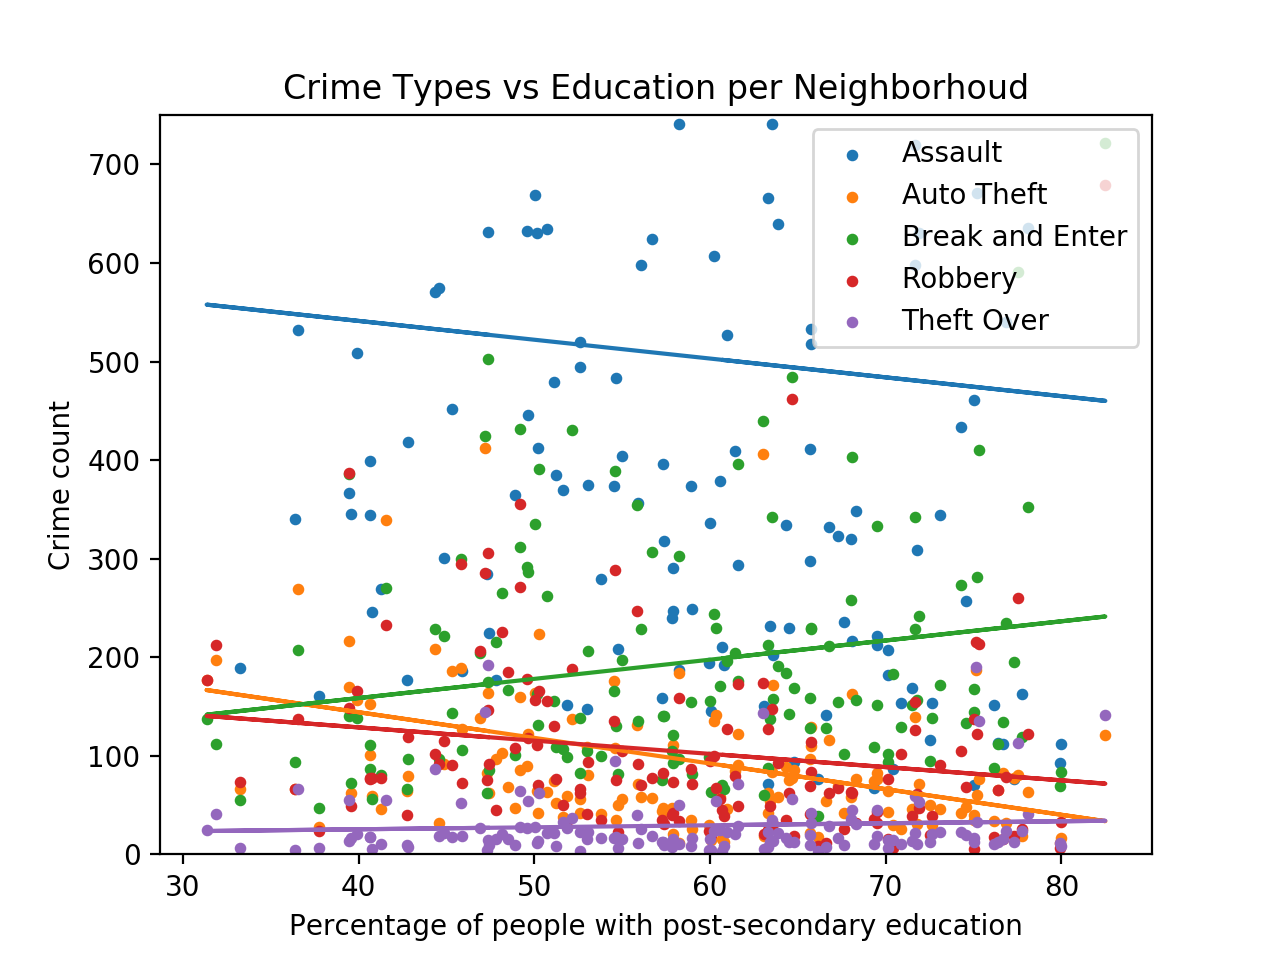

In [70]:
plt.scatter(crimes_with_education['no_degree %'],crimes_with_education['crime_count'], s=10, label='No Degree')  
plt.scatter(crimes_with_education['highschool %'],crimes_with_education['crime_count'], s=10, label='Highschool Degree')               
plt.scatter(crimes_with_education['higher %'],crimes_with_education['crime_count'], s=10, label='Post-secondary Degree')            

plt.legend()
plt.title('Crime Counts vs Education per Neighborhoud')
plt.xlabel('Percentage of people with post-secondary education')
plt.ylabel('Crime count')
plt.show()

In [ ]:
# doesn't look like much of a correlation

In [36]:
# lets see if it differs per type of crime

In [37]:
# types of indicators
MCIs = list(crimes_df.groupby('MCI').groups)
MCIs

['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']

In [38]:
crimes_count_by_type = crimes_df.groupby(['hood_id', 'MCI'])['event_unique_id'].count()
crimes_counts_by_type_df = crimes_count_by_type.to_frame().unstack('MCI')

In [39]:
crimes_counts_by_type_df.head()

event_unique_id                                              
MCI             Assault Auto Theft Break and Enter Robbery Theft Over
hood_id                                                              
1                  1082       1181             503     306        192
2                  1048        217             140     387         14
3                   225         62              86      92         10
4                   285         83              62      75          4
5                   246         59              56      78          5

In [42]:
crimes_types_vs_education = pd.merge(crimes_counts_by_type_df,education_by_neighborhood, on='hood_id')
crimes_types_vs_education.columns = ['Assault','Auto Theft','Break and Enter','Robbery','Theft Over', 'No Degree %', 'Highschool %', 'Post-secondary %']
crimes_types_vs_education.head()

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,Assault,Auto Theft,Break and Enter,Robbery,Theft Over,No Degree %,Highschool %,Post-secondary %
hood_id,,,,,,,,
1,1082,1181,503,306,192,21.711624,30.942861,47.345515
2,1048,217,140,387,14,30.363227,30.199156,39.437617
3,225,62,86,92,10,24.651538,27.933076,47.415387
4,285,83,62,75,4,22.421935,30.246291,47.331774
5,246,59,56,78,5,25.276329,33.990772,40.732899


In [76]:
plt.clf() #clear previous plot
for MCI in MCIs:
    plt.scatter(crimes_types_vs_education['Post-secondary %'],crimes_types_vs_education[MCI], s=10)                
plt.legend()
plt.ylim(0,750)
plt.title('Crime Types vs Education per Neighborhoud')
plt.xlabel('Percentage of people with post-secondary education')
plt.ylabel('Crime count')
plt.show()

In [77]:
# correlation isnt clear, lets try a linear regression

In [78]:
x = crimes_types_vs_education['Post-secondary %']
for MCI in MCIs:
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, crimes_types_vs_education[MCI])
    plt.plot(x,intercept + slope*x)     
plt.savefig('../output/crimes-vs-education')

### Trends:
### - Assault rates, auto theft and robbery, decrease in neighborhoods with higher education levels, but the effect is not that large
### - Break and enter occurances are a little higher in neighborhoods with higher education levels (nicer houses)
### - Income and education graphs are very very similar (confirms correlation between income and education)